In [1]:
from keras.utils import np_utils
import numpy as np
import time
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 18
from tqdm import tqdm
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint  
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image    
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import datetime as dt
%matplotlib inline


Using TensorFlow backend.


In [2]:
# Data Directory Setup
train_dir = './train/'
test_dir = './test/'

In [3]:

# Data Exploration
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
no_categories = len(categories)
print ("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print ("The number of category is {}".format(no_categories))
print ("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print ("Here are the training data intel:")

for cat in categories:
    print('-{} {} images'.format(cat, len(os.listdir(os.path.join(train_dir, cat)))))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The number of category is 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Here are the training data intel:
-Black-grass 263 images
-Charlock 390 images
-Cleavers 287 images
-Common Chickweed 611 images
-Common wheat 221 images
-Fat Hen 475 images
-Loose Silky-bent 654 images
-Maize 221 images
-Scentless Mayweed 516 images
-Shepherds Purse 231 images
-Small-flowered Cranesbill 496 images
-Sugar beet 385 images


In [4]:
# Create Training Data DataFrame
def create_training_df(train_dir, categories):
    train = []
    for cat_id, cat in enumerate(categories):
        for file in os.listdir(os.path.join(train_dir, cat)):
            train.append([train_dir + '{}/{}'.format(cat, file), cat_id, cat])
    train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])

    return train

In [5]:
train_df = create_training_df(train_dir, categories)
print ("There are {} training items".format(len(train_df)))
train_df.head(10)


There are 4750 training items


,file,category_id,category
0,./train/Black-grass/e47987eab.png,0,Black-grass
1,./train/Black-grass/7b72b398d.png,0,Black-grass
2,./train/Black-grass/f4b7ddbce.png,0,Black-grass
3,./train/Black-grass/6e193f1bb.png,0,Black-grass
4,./train/Black-grass/c025e2886.png,0,Black-grass
5,./train/Black-grass/686132594.png,0,Black-grass
6,./train/Black-grass/ac47ebc4d.png,0,Black-grass
7,./train/Black-grass/3a8c485bc.png,0,Black-grass
8,./train/Black-grass/957b8523c.png,0,Black-grass
9,./train/Black-grass/4a3b96198.png,0,Black-grass


In [6]:
def create_testing_df(test_dir):
    test = []
    for file in os.listdir(test_dir):
        test.append([test_dir+file])
    test = pd.DataFrame(test, columns=['file'])

    return test

In [7]:
test_df = create_testing_df(test_dir)
print ("There are {} testing items".format(len(test_df)))
test_df.head(10)

There are 794 testing items


,file
0,./test/77ccb8b2a.png
1,./test/3b73c3b61.png
2,./test/dc55449b2.png
3,./test/da4ed3a28.png
4,./test/8ab8a958b.png
5,./test/e5e3dccff.png
6,./test/659412b1a.png
7,./test/e5064f6be.png
8,./test/03a2ee656.png
9,./test/ef74dbcad.png


In [8]:
# Function to read image
def read_image(path, size):
    img = image.load_img(path, target_size=size)
    img = image.img_to_array(img)
    return img

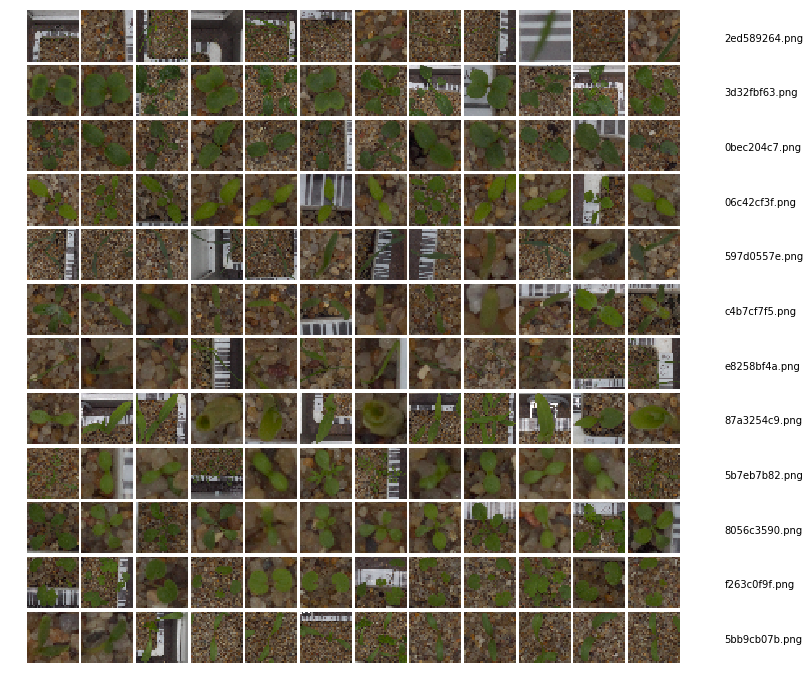

In [9]:
# Showing Image Data
fig = plt.figure(1, figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(no_categories, no_categories), axes_pad=0.05)
i = 0
for category_id, category in enumerate(categories):
    for filepath in train_df[train_df['category'] == category]['file'].values[:no_categories]:
        ax = grid[i]
        img = read_image(filepath, (32, 32))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % no_categories == no_categories - 1:
            ax.text(60, 17, filepath.split('/')[3], verticalalignment='center')
        i += 1
plt.show();

In [10]:
# Data Shuffling and Splitting
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head(10)

,file,category_id,category
0,./train/Maize/2d9adb800.png,7,Maize
1,./train/Charlock/c291766ce.png,1,Charlock
2,./train/Small-flowered Cranesbill/909da3410.png,10,Small-flowered Cranesbill
3,./train/Loose Silky-bent/bdd598dec.png,6,Loose Silky-bent
4,./train/Common Chickweed/7d7675873.png,3,Common Chickweed
5,./train/Fat Hen/e6befd0af.png,5,Fat Hen
6,./train/Common Chickweed/d14306ba9.png,3,Common Chickweed
7,./train/Loose Silky-bent/9a2b47af1.png,6,Loose Silky-bent
8,./train/Charlock/bec896ebd.png,1,Charlock
9,./train/Scentless Mayweed/523edb175.png,8,Scentless Mayweed


In [11]:
np.random.seed(seed=12)
rnd = np.random.random(len(train_df))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
Y_train = train_df.loc[train_idx, 'category_id'].values
Y_valid = train_df.loc[valid_idx, 'category_id'].values
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
len(Y_train), len(Y_valid)

(3800, 950)

In [12]:
input_size = 224
X_Data = np.zeros((len(train_df), input_size, input_size, 3), dtype='float32')
for i, file in tqdm(enumerate(train_df['file'])):
    img = read_image(file, (input_size, input_size))
    img = preprocess_input(np.expand_dims(img.copy(), axis=0))
    X_Data[i] = img
print('Train Images shape: {} size: {:,}'.format(X_Data.shape, X_Data.size))


4750it [01:00, 78.55it/s]

Train Images shape: (4750, 224, 224, 3) size: 715,008,000


In [13]:
X_train = X_Data[train_idx]
X_valid = X_Data[valid_idx]
len(X_train), len(X_valid)

(3800, 950)

In [14]:
print((X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape))

((3800, 224, 224, 3), (950, 224, 224, 3), (3800, 12), (950, 12))


In [15]:
# Dummy Data
XT_dummy = X_train[:256]
YT_dummy = Y_train[:256]
XV_dummy = X_valid[:256]
YV_dummy = Y_valid[:256]
print((XT_dummy.shape, XV_dummy.shape, YT_dummy.shape,  YV_dummy.shape))

((256, 224, 224, 3), (256, 224, 224, 3), (256, 12), (256, 12))


In [16]:
# Reading Test Data
X_Test = np.zeros((len(test_df), input_size, input_size, 3), dtype='float32')
for i, file in tqdm(enumerate(test_df['file'])):
    img = read_image(file, (input_size, input_size))
    img = preprocess_input(np.expand_dims(img.copy(), axis=0))
    X_Test[i] = img
print('Test Images shape: {} size: {:,}'.format(X_Test.shape, X_Test.size))


794it [00:03, 205.21it/s]

Test Images shape: (794, 224, 224, 3) size: 119,519,232


In [17]:
print(X_Test.shape)

(794, 224, 224, 3)


In [18]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

In [19]:
# define pre-trained models
# VGG16_model = VGG16(include_top=False, weights="imagenet", pooling="avg", classes=12)

# VGG_16 Model
img_rows, img_cols = 224, 224
def VGG_16(img_rows, img_cols, color_type=1):
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(img_rows, img_cols, color_type)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    
    model.load_weights('./pre_trained_model/vgg16_weights.h5', by_name=True)

    # Code above loads pre-trained data and
    model.pop()
    model.add(Dense(12, activation='softmax', kernel_initializer='glorot_normal'))
    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy', fscore])
    print('model loading and compilation finished succesfully')    

    return model

VGG16_model = VGG_16(224, 224, 3)
VGG16_model.summary()

/home/rezachu/anaconda3/envs/TF/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  if __name__ == '__main__':
/home/rezachu/anaconda3/envs/TF/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/home/rezachu/anaconda3/envs/TF/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
/home/rezachu/anaconda3/envs/TF/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/home/rezachu/anaconda3/envs/TF/lib/python3.5/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the

model loading and compilation finished succesfully
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)        

In [20]:
print((X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape))
print((XT_dummy.shape, XV_dummy.shape, YT_dummy.shape,  YV_dummy.shape))



    
# grid search epochs, batch size and optimizer
# optimizers = ['rmsprop', 'adam']
# epochs = [5, 10, 20, 50]
# batches = [32, 64, 128]


epochs = [20]
batch_size = [32]
start = time.time()
# checkpointer = ModelCheckpoint(filepath="./saved_models/weights-{epoch:02d}-{val_acc:.2f}-{val_fscore:.2f}.hdf5", 
#                                verbose=1, save_best_only=True)
# VGG16_model.fit(XT_dummy, YT_dummy, validation_data=(XV_dummy, YV_dummy), epochs=10, batch_size=32, callbacks=[checkpointer], verbose=1)
for epoch in epochs:
    for batch in batch_size:
        checkpointer = ModelCheckpoint(filepath="./saved_models/"+"epochs_"+ str(epoch) + "-batch_size_"+ str(batch) +"-weights-best.hdf5", 
                               verbose=1, save_best_only=True)
        VGG16_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=epoch, batch_size=batch, callbacks=[checkpointer], verbose=1)
        

end = time.time()
print (end-start)

((3800, 224, 224, 3), (950, 224, 224, 3), (3800, 12), (950, 12))
((256, 224, 224, 3), (256, 224, 224, 3), (256, 12), (256, 12))
Train on 3800 samples, validate on 950 samples
Epoch 1/20
3800/3800 [==============================] - 144s 38ms/step - loss: 2.4417 - acc: 0.1300 - fscore: 0.0000e+00 - val_loss: 2.4202 - val_acc: 0.1221 - val_fscore: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.42020, saving model to ./saved_models/epochs_20-batch_size_32-weights-best.hdf5
Epoch 2/20
3800/3800 [==============================] - 126s 33ms/step - loss: 2.4186 - acc: 0.1392 - fscore: 0.0000e+00 - val_loss: 2.3738 - val_acc: 0.1221 - val_fscore: 0.0000e+00

Epoch 00002: val_loss improved from 2.42020 to 2.37383, saving model to ./saved_models/epochs_20-batch_size_32-weights-best.hdf5
Epoch 3/20
3800/3800 [==============================] - 126s 33ms/step - loss: 2.3420 - acc: 0.1808 - fscore: 0.0053 - val_loss: 2.1837 - val_acc: 0.3168 - val_fscore: 0.0000e+00

Epoch 00003: val_loss i

In [22]:
# Predict it on our Test set and print out some result
test_result = VGG16_model.predict(X_Test, batch_size=32, verbose=1)
print(test_result)
print (len(test_result))

794/794 [==============================] - 10s 12ms/step
[[1.4020975e-07 2.8378723e-08 2.2473380e-07 ... 3.9145038e-05
  9.9987638e-01 6.7847136e-06]
 [7.1565759e-01 1.6113462e-06 8.3908402e-05 ... 7.1742834e-06
  6.9089033e-06 1.7984911e-03]
 [1.6924091e-02 5.4171320e-05 1.3622480e-03 ... 1.8244076e-03
  1.2277649e-03 9.2084402e-01]
 ...
 [9.8535842e-05 2.6646495e-02 9.0632665e-01 ... 1.7535334e-02
  1.6817721e-03 1.4116190e-03]
 [4.9134944e-02 3.8515358e-05 4.4901767e-03 ... 7.5060125e-05
  2.1914228e-05 9.5236897e-02]
 [1.1458377e-03 3.8063365e-07 5.8163860e-04 ... 1.7252769e-05
  2.5331865e-05 9.9044526e-01]]
794


In [23]:
# Create submission.csv accounting to the required format
submission = pd.DataFrame()
file, species = [], [] 
for i in range(len(test_result)):
    file.append(test_df['file'][i].split('/')[2])
    idx = np.argmax(test_result[i], axis=None, out=None)
    species.append(categories[idx])
submission['file'] = file
submission['species'] = species

submission.to_csv('submission_trial2.csv', sep=',', index= False)